In [61]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import os
import random
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto
from sklearn.metrics import roc_auc_score, roc_curve
from efficientnet_pytorch import EfficientNet
from collections import Counter
import itertools
import copy

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
torch.cuda.is_available()

True

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating the Siamese Dataset

In [66]:
def get_all_subjects_from_a_folder(root_dir: str):
  """Gets all folders within the "root_dir" folder"""
  return os.listdir(root_dir)

def get_all_images_from_a_subject(root_dir: str, subject_id: str):
  """Gets all images from a subject folder"""
  subject_dir = create_subject_path(root_dir, subject_id)
  return get_all_subjects_from_a_folder(subject_dir)

def create_subject_path(root_dir: str, subject_id: str):
  """Joins the path of the root_dir with the subject_id"""
  return os.path.join(root_dir, subject_id)

def create_positive_images_for_subject(root_dir: str, subject_id: str, selected_img: str):
  """Gets all the same images from a subject that are not the subject.
  
  Note! The selected image is a relative path from the subject_dir, so 
  just the image name"""
  all_images = get_all_images_from_a_subject(root_dir, subject_id)

  all_images_different_from_subj = [
      image_name for image_name in all_images
      if image_name != selected_img
  ]

  n_images = len(all_images_different_from_subj)

  return all_images_different_from_subj, n_images

def create_negative_images_for_subject(root_dir: str, subject_id, n_images):
  """Gets negtive images from a subject_id (images that are not from the 
  subject_id). The number of images is equal to n_images."""
  all_subjects = get_all_subjects_from_a_folder(root_dir)

  all_subjects_different_from_selected = [
      subj for subj in all_subjects
      if subj != subject_id
  ]

  selected_subjects = np.random.choice(
      all_subjects_different_from_selected,
      size = n_images,
      replace=True
  )

  selected_images = np.array([])

  for subj in selected_subjects:
    subj_path = create_subject_path(root_dir, subj)
    all_images_subj = get_all_images_from_a_subject(subj_path)
    selection = np.random.choice(
        all_images_subj, 
        size = 1, 
    )

    selected_images = np.append(selected_images, selection)

  return selected_images

In [67]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.subjects = [subj for subj in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, subj))]
        self.subject_to_images = {subject: os.listdir(os.path.join(root_dir, subject)) for subject in self.subjects}

    def __len__(self):
        total_images = 0
        for subject_images in self.subject_to_images.values():
            total_images += len(subject_images)
        return total_images

    def __getitem__(self, index):
        anchor_subject, anchor_image_path = self.get_subject_image_path(index)
        positive_image_path = self.get_positive_image(anchor_subject, anchor_image_path)
        negative_image_path = self.get_negative_image(anchor_subject)

        anchor_image = Image.open(anchor_image_path).convert("RGB")
        positive_image = Image.open(positive_image_path).convert("RGB")
        negative_image = Image.open(negative_image_path).convert("RGB")

        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

    def get_subject_image_path(self, index):
        subject_index = 0
        subject = self.subjects[subject_index]
        count = len(self.subject_to_images[subject])

        while index >= count:
            index -= count
            subject_index += 1
            subject = self.subjects[subject_index]
            count = len(self.subject_to_images[subject])

        image_name = self.subject_to_images[subject][index]
        image_path = os.path.join(self.root_dir, subject, image_name)
        return subject, image_path

    def get_positive_image(self, anchor_subject, anchor_image_path):
        subject_images = self.subject_to_images[anchor_subject]
        positive_image_name = random.choice([img for img in subject_images if os.path.join(anchor_subject, img) != anchor_image_path])
        positive_image_path = os.path.join(self.root_dir, anchor_subject, positive_image_name)
        return positive_image_path

    def get_negative_image(self, anchor_subject):
        negative_subject = random.choice([subj for subj in self.subjects if subj != anchor_subject])
        negative_image_name = random.choice(self.subject_to_images[negative_subject])
        negative_image_path = os.path.join(self.root_dir, negative_subject, negative_image_name)
        return negative_image_path


In [68]:
class BalancedTripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.subjects = [subj for subj in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, subj))]
        self.subject_to_images = {subject: os.listdir(os.path.join(root_dir, subject)) for subject in self.subjects}
        self.triplets = self.generate_triplets()

    def generate_triplets(self):
        triplets = []
        for subject in self.subjects:
            subject_images = self.subject_to_images[subject]
            positive_pairs = list(itertools.combinations(subject_images, 2))
            for anchor_img, positive_img in positive_pairs:
                anchor_image_path = os.path.join(self.root_dir, subject, anchor_img)
                positive_image_path = os.path.join(self.root_dir, subject, positive_img)
                triplets.append((anchor_image_path, positive_image_path, subject))
        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, index):
        anchor_image_path, positive_image_path, anchor_subject = self.triplets[index]
        negative_image_path = self.get_negative_image(anchor_subject)

        anchor_image = Image.open(anchor_image_path).convert("RGB")
        positive_image = Image.open(positive_image_path).convert("RGB")
        negative_image = Image.open(negative_image_path).convert("RGB")

        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

    def get_negative_image(self, anchor_subject):
        negative_subject = random.choice([subj for subj in self.subjects if subj != anchor_subject])
        negative_image_name = random.choice(self.subject_to_images[negative_subject])
        negative_image_path = os.path.join(self.root_dir, negative_subject, negative_image_name)
        return negative_image_path


In [69]:
train_dataset = TripletDataset(root_dir="/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train", transform=None)
len(train_dataset)

296

In [70]:
train_dataset = BalancedTripletDataset(root_dir="/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train", transform=None)
len(train_dataset)

2107

In [71]:
train_dataset = TripletDataset(root_dir="/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train", transform=None)

In [72]:
train_dataset.get_subject_image_path(0)

('14',
 '/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train/14/032423001682.JPG')

In [73]:
train_dataset.get_positive_image('14', '/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train/14/032423001682.JPG')

'/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train/14/032423001684.JPG'

### Calling the Siamese Dataset

In [74]:
img_size = 224

train_imgs_path = "/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Train"
test_imgs_path  = "/content/drive/MyDrive/ULTRADATA/Motos_reencuadradas/Test"

transform_train = transforms.Compose([
  transforms.Resize((img_size, img_size)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  # , transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

transform_valid = transforms.Compose([
    transforms.Resize((img_size, img_size)), # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


siamese_train_dataset = BalancedTripletDataset(root_dir=train_imgs_path, transform=transform_train)
siamese_test_dataset = BalancedTripletDataset(root_dir=test_imgs_path, transform=transform_valid)

### Calling the Siamese DataLoader

In [75]:
batch_size = 32
shuffle = True
num_workers = 2

siamese_train_dataloader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
siamese_val_dataloader   = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Creating the Siamese Network

### EfficientNet Feature Extractor

In [76]:
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, model_name='efficientnet-b0', pretrained=True):
        super(EfficientNetFeatureExtractor, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained(model_name) if pretrained else EfficientNet.from_name(model_name)

        # Get the number of output features from the EfficientNet model
        num_output_features = self.efficient_net._fc.in_features

        # Remove the classification head to use it as a feature extractor
        self.efficient_net._fc = nn.Identity()

        # Define the fully connected layer with the appropriate input size
        self.fc = nn.Linear(num_output_features, 256)  # 128

        # Add a normalization layer
        self.norm = nn.BatchNorm1d(256)  # 128

        # Freeze the pre-trained EfficientNet model parameters
        for param in self.efficient_net.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.efficient_net(x)
        x = self.fc(x)
        x = self.norm(x)
        return x

### Siamese Network on top of feature extractor

In [77]:
class SiameseNetwork(nn.Module):
    def __init__(self, feature_extractor, model_name, init_method, batch_norm, learning_rate, epochs, dataset, loss_function, accuracy_threshold, img_size):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = feature_extractor

        # Define parameters for saving:
        self.name = model_name
        self.init_method = init_method
        self.batch_norm = batch_norm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.dataset = dataset
        self.loss_function = loss_function
        self.img_size = img_size

    def forward(self, anchor, positive, negative):
        output1 = self.feature_extractor(anchor)
        output2 = self.feature_extractor(positive)
        output3 = self.feature_extractor(negative)
        return output1, output2, output3

    def compare_images(self, preprocessed_image1, preprocessed_image2, threshold):
        self.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            # Extract the feature vectors for the two images
            feature_vector1 = self.feature_extractor(preprocessed_image1)
            feature_vector2 = self.feature_extractor(preprocessed_image2)

            # Calculate the similarity between the feature vectors
            similarity = torch.norm(feature_vector1 - feature_vector2).item()

        # Compare the similarity to the threshold and return the result
        return similarity <= threshold # <= threshold   # Add for returning a True/False


### Auxiliar functions for the model

In [78]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def unfreeze_layers(model, num_layers_to_unfreeze):
    ct = 0
    children_list = list(model.children())
    for child in reversed(children_list):
        ct += 1
        if ct <= num_layers_to_unfreeze:
            for param in child.parameters():
                param.requires_grad = True
        else:
            break

### Creating the model

In [79]:
feature_extractor = EfficientNetFeatureExtractor(model_name='efficientnet-b0', pretrained=True)

siamese_network = SiameseNetwork(
    feature_extractor=feature_extractor, 
    model_name="EfficientNet", 
    init_method=None, 
    batch_norm=None, 
    learning_rate=1e-4, 
    epochs=20, 
    dataset="Motos_recortes", 
    loss_function="triplet_loss", 
    accuracy_threshold=0.5, 
    img_size=img_size
)

siamese_network.to(device)

n_params = count_trainable_parameters(siamese_network)
print(f"Model's trainable parameters: {n_params}")

Loaded pretrained weights for efficientnet-b0
Model's trainable parameters: 328448


### Loss Function

In [80]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.nn.functional.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [81]:
loss_function = TripletLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, siamese_network.parameters()), lr=siamese_network.learning_rate)

### Accuracy Function:

In [82]:
def batch_accuracy(anchor_out, positive_out, negative_out):
    """Function that calculates the LOCAL accuracy. This accuracy is not 
    the final one, it just serves as a way to measure if the model is 
    improving.
    """
    positive_distance = (anchor_out - positive_out).pow(2).sum(1).sqrt()
    negative_distance = (anchor_out - negative_out).pow(2).sum(1).sqrt()

    correct = (positive_distance < negative_distance).sum().item()
    total = anchor_out.size(0)

    accuracy = correct / total
    return accuracy

# Train

In [83]:
epochs = siamese_network.epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

# Create a parent progress bar for epochs
epoch_pbar = tqdm_auto(range(epochs), desc="Epochs", leave=True)

for epoch in epoch_pbar:
    # Training loop
    siamese_network.train()
    train_loss = 0.0
    train_accuracy = 0.0

    # Create a child progress bar for the training loop
    train_pbar = tqdm_auto(enumerate(siamese_train_dataloader), total=len(siamese_train_dataloader), desc="Training", leave=False)

    for batch, (image_batch_anchor, image_batch_positive, image_batch_negative) in train_pbar:

        image_batch_anchor = image_batch_anchor.to(device)
        image_batch_positive = image_batch_positive.to(device)
        image_batch_negative = image_batch_negative.to(device)

        anchor, positive, negative = siamese_network(image_batch_anchor, image_batch_positive, image_batch_negative)
        loss = loss_function(anchor, positive, negative)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += batch_accuracy(anchor, positive, negative)

    train_loss /= len(siamese_train_dataloader)
    train_accuracy /= len(siamese_train_dataloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    siamese_network.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    # Create a child progress bar for the validation loop
    val_pbar = tqdm_auto(enumerate(siamese_val_dataloader), total=len(siamese_val_dataloader), desc="Validation", leave=False)
  
    with torch.inference_mode():
        for batch, (image_batch_anchor, image_batch_positive, image_batch_negative) in val_pbar:
            
            image_batch_anchor = image_batch_anchor.to(device)
            image_batch_positive = image_batch_positive.to(device)
            image_batch_negative = image_batch_negative.to(device)

            anchor, positive, negative = siamese_network(image_batch_anchor, image_batch_positive, image_batch_negative)
            loss = loss_function(anchor, positive, negative)

            val_loss += loss.item()
            val_accuracy += batch_accuracy(anchor, positive, negative)

    val_loss /= len(siamese_val_dataloader)
    val_accuracy /= len(siamese_val_dataloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = copy.deepcopy(siamese_network.state_dict())
        save_string = f" <--- Saved model (Best Validation Accuracy)"
    else:
        save_string = f""

    # Update the parent progress bar description
    epoch_pbar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    epoch_pbar.refresh()

    # print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}{save_string}")

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/66 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

In [94]:
# Load the best model
siamese_network.load_state_dict(best_model)

<All keys matched successfully>

In [95]:
text_train_accuracy = str(round(train_accuracy * 100, 0)).replace(".", ",")
text_valid_accuracy = str(round(val_accuracy * 100, 0)).replace(".", ",")
epochs = siamese_network.epochs
dataset = siamese_network.dataset
loss_fn = siamese_network.loss_function
model_name = siamese_network.name
lr = siamese_network.learning_rate

model_path = f"""/content/drive/MyDrive/ULTRADATA/trained_models/name-{model_name}_lr-{lr}_valid-acc-{text_valid_accuracy}_train-acc-{text_train_accuracy}_epochs-{epochs}_dataset-{dataset}_loss-fn-{loss_fn}.pth"""

print(model_path)

/content/drive/MyDrive/ULTRADATA/trained_models/name-EfficientNet_lr-0.0001_valid-acc-92,0_train-acc-96,0_epochs-20_dataset-Motos_recortes_loss-fn-triplet_loss.pth


In [96]:
torch.save(siamese_network.state_dict(), model_path)

# Testing the model:

In [97]:
for data in siamese_val_dataloader:
  batch_anchor, batch_positive, batch_negative = data
  break

In [104]:
index = 0

base_img = batch_anchor[index, :, :, :].unsqueeze(0).to(device)
pos_img  = batch_positive[index, :, :, :].unsqueeze(0).to(device)
neg_img  = batch_negative[index, :, :, :].unsqueeze(0).to(device)

In [105]:
siamese_network.compare_images(base_img, neg_img, 0.5)

False

In [106]:
def unnormalize_image(image, mean, std):
    img = image.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

In [107]:
def visualize_predictions(network, image1, image2, exp_label, threshold = 0.5, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    network.eval()

    prediction = network.compare_images(image1, image2, threshold)

    unnormalized_img1 = unnormalize_image(image1.squeeze(0), mean, std)
    unnormalized_img2 = unnormalize_image(image2.squeeze(0), mean, std)

    # Concatenate the images horizontally
    concatenated_images = torch.cat((unnormalized_img1, unnormalized_img2), dim=2)
    unnorm_concatenated_images = concatenated_images.permute(1, 2, 0).cpu().numpy()

    # Display the concatenated images
    plt.figure(figsize=(15, 5))
    plt.imshow(unnorm_concatenated_images)
    plt.title(f"   Image 1   | Prediction: {prediction}  --> Expected: {exp_label} |   Image 2     ")
    plt.axis("off")
    plt.show()


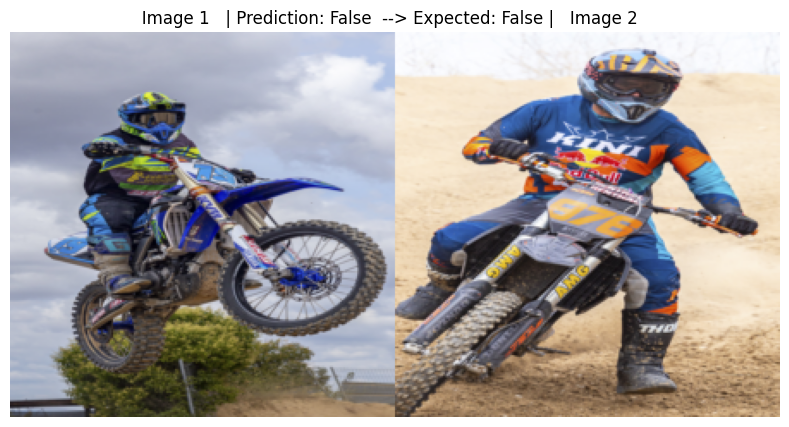

In [108]:
visualize_predictions(siamese_network, base_img, neg_img, False)

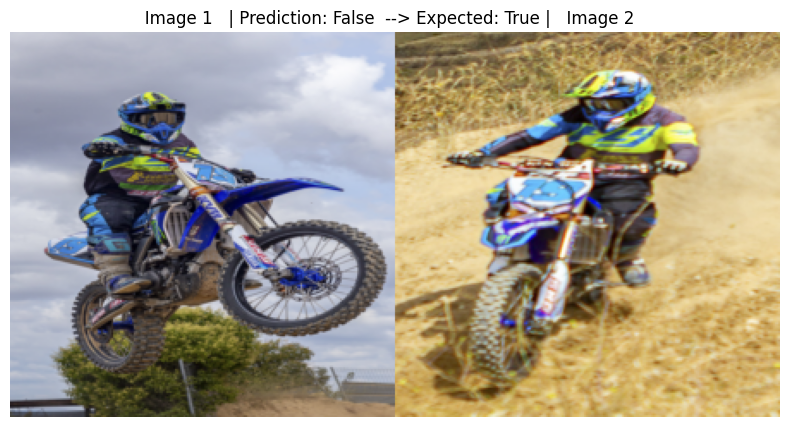

In [109]:
visualize_predictions(siamese_network, base_img, pos_img, True)

In [93]:
# img1 = siamese_test_dataset[0][0].to(device).unsqueeze(0)
# img2 = siamese_test_dataset[0][1].to(device).unsqueeze(0)

# image1 = transform_valid(Image.open(im1_path).convert("RGB")).unsqueeze(0).to(device)
# image2 = transform_valid(Image.open(im1_path_pos).convert("RGB")).unsqueeze(0).to(device)

# image1.shape
siamese_network.compare_images(base_img, pos_img, 0.5)

False

In [114]:
batch_anchor, batch_positive, batch_negative = batch_anchor.to(device), batch_positive.to(device), batch_negative.to(device)

siamese_network.eval()
output = siamese_network(batch_anchor, batch_positive, batch_negative)

In [119]:
torch.nn.functional.pairwise_distance(output[0], output[2])

tensor([20.3419, 17.5511, 18.0096, 16.6556, 20.6369, 17.9314, 14.9262, 15.6495,
        25.7560, 18.6934, 19.1452, 19.9686, 18.7808, 21.9480, 18.6100, 15.3856,
        21.1326, 13.6941, 13.2238, 27.3046, 25.8938, 15.4225, 17.4245, 17.4798,
        19.3938, 19.2233, 18.2074, 15.2837, 27.9799, 16.7216, 25.6377, 19.7972],
       device='cuda:0', grad_fn=<NormBackward1>)

In [120]:
torch.norm(output[0], output[2]).item()

TypeError: ignored

In [121]:
output[0]

tensor([[ 0.1136,  0.8669,  0.5082,  ..., -0.3085, -0.5114, -0.1028],
        [-0.8148, -0.8316,  1.4067,  ...,  0.9752, -1.1665, -0.2987],
        [ 1.7792, -0.3287, -0.7716,  ..., -0.1453,  0.6631,  0.1093],
        ...,
        [ 1.7792, -0.3287, -0.7716,  ..., -0.1453,  0.6631,  0.1093],
        [-0.0305,  0.1232, -2.6115,  ..., -0.2698, -0.2808, -1.1412],
        [ 0.2294, -0.6292, -0.3774,  ...,  0.0865,  0.8869,  0.7809]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)